In [1]:
# python
import os
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.ndimage import label
from tqdm import tqdm

# plot
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# neural networks
import torch, torch.utils.model_zoo  # required to load nets
from torchvision.models.feature_extraction import (
    get_graph_node_names,
    create_feature_extractor,
)

# thesis library
from lib.functions_scripting import *
from lib.functions_base_analysis import *
from lib.functions_second_analysis import *

from lib.ImageDataset import ImageDataset
from lib.NetworkScorer import NetworkScorer
from lib.PatternGenerator import Pattern_Generator
from lib.ActivationPattern import Activation_Pattern
from lib.transforms import VisualPriorRepresentation
from lib.PatternGeneratorSearchlight import PatternGeneratorSearchlight


PATH_SSINT = os.path.join(PATH_RESULTS, "spatial integration", "subset integration")
PATH_SSIBC = os.path.join(PATH_RESULTS, "spatial integration", "subset ibcorr")
PATH_3DPVAL = os.path.join(PATH_RESULTS, "spatial integration", "subset 3d pvalues")
PATH_3DCORR = os.path.join(PATH_RESULTS, "spatial integration", "subset 3d correlation")
PATH_PERMDISTR_TOPVOXELS_CLUSTERSIZE = os.path.join(
    PATH_RESULTS, "spatial integration", "permutation distributions", "topvoxels clustersize"
)
PATH_SIGNICLUST = os.path.join(PATH_RESULTS, "spatial integration", "significant clusters")

beauty_ratings = load_ratings(PATH_RATINGS)
modelorder = pd.read_pickle(os.path.join(PATH_RESULTS, "model order.pkl"))
BLOCKING_GROUPS = np.insert(np.repeat(range(1, 16 + 1), 3), 0, 0)

In [2]:
_models = modelorder[10:].index.to_list()
_studies = STUDY_NAMES
_datasets = DATASET_NAMES
_scales = SCALE_NAMES[:4]

In [3]:
# unblocked data
_blocking = "unblocked"
_layers = slice(None)

dfi = load_integration(PATH_INTEGRATION)
dfibc = load_ibcorr(PATH_IBCORR)

dfi = dfi.sort_index().loc[(_models, _datasets, _scales, slice(None), _layers)]
dfibc = dfibc.sort_index().loc[(_models, _studies, _scales, _layers)]

# best predicting models & layers

In [140]:
bestlayers = (
    dfibc.groupby(["model", "study", "scale"])
    .agg(corr=("ibcorr", max), layer=("ibcorr", lambda x: x.idxmax()[-1]))
    .reorder_levels(["scale", "study", "model"])
    .sort_index()
).loc[(_scales, _studies, _models)]


laysize_table = pd.DataFrame(np.nan, index=range(48 + 1), columns=["layersize"])
for i in np.diff(BLOCKING_GROUPS).nonzero()[0]:
    laysize_table.loc[i:] = get_layer_size(i)

bestlayers = bestlayers.assign(
    laysize=bestlayers.layer.transform(
        lambda x: laysize_table.loc[x].values[0].astype(int)
    )
)
bestlayers

corr  layer  laysize
scale   study              model                                     
scale2  short presentation class_scene       0.374823     17    65536
                           egomotion         0.205430      6    16384
                           autoencoding      0.045450     40   262144
                           reshading         0.405152     20    65536
                           edge_occlusion    0.321020     32   262144
...                                               ...    ...      ...
scale16 oasis              jigsaw            0.166900      3    16384
                           segment_unsup25d  0.186501     26   262144
                           point_matching    0.088931      1     9408
                           keypoints2d       0.153323     15    65536
                           vanishing_point   0.176404      3    16384

[208 rows x 3 columns]

### scale 2: reshading(20) 

In [204]:
bestlayers.loc[("scale2", slice(None), slice(None))].groupby("study").apply(
    lambda df: df.sort_values("corr")
).droplevel(0).loc[list(_studies)].groupby("study").tail(3)

corr  layer  laysize
study              model                                    
short presentation vanishing_point  0.347481     28   262144
                   class_scene      0.374823     17    65536
                   reshading        0.405152     20    65536
long presentation  vanishing_point  0.302165     28   262144
                   class_scene      0.335656     17    65536
                   reshading        0.377791     20    65536
complexity order   vanishing_point  0.353357     18    65536
                   reshading        0.366724     20    65536
                   class_scene      0.386800     17    65536
oasis              reshading        0.160978     20    65536
                   vanishing_point  0.187504      6    16384
                   segment_unsup2d  0.188171      9    16384

### scale 4: segment_unsup2d(41)

In [10]:
bestlayers.loc[("scale4", slice(None), slice(None))].groupby("study").apply(
    lambda df: df.sort_values("corr")
).droplevel(0).loc[list(_studies)].groupby("study").tail(5)

corr  layer  laysize
study              model                                     
short presentation segment_unsup25d  0.413453     36   262144
                   vanishing_point   0.422424     28   262144
                   keypoints3d       0.422735     41   262144
                   edge_occlusion    0.428372     32   262144
                   segment_unsup2d   0.464074     41   262144
long presentation  keypoints3d       0.391302     41   262144
                   vanishing_point   0.392898     28   262144
                   edge_occlusion    0.399783     32   262144
                   reshading         0.411068     38   262144
                   segment_unsup2d   0.441788     41   262144
complexity order   segment_unsup2d   0.403273     35   262144
                   edge_occlusion    0.407059     32   262144
                   segment_unsup25d  0.429413     35   262144
                   keypoints3d       0.441996     41   262144
                   reshading         0.454562     46  1048576
oasis              reshading         0.173703     26   262144
                   jigsaw            0.184901      9    16384
                   vanishing_point   0.192614      6    16384
                   segment_unsup25d  0.214946     20    65536
                   segment_unsup2d   0.217433     16    65536

### scale 8: vanishing point(18) 

In [12]:
bestlayers.loc[("scale8", slice(None), slice(None))].groupby("study").apply(
    lambda df: df.sort_values("corr")
).droplevel(0).loc[list(_studies)].groupby("study").tail(5)

corr  layer  laysize
study              model                                     
short presentation reshading         0.367198     38   262144
                   edge_occlusion    0.411349     32   262144
                   keypoints3d       0.422174     31   262144
                   segment_unsup25d  0.439146     32   262144
                   vanishing_point   0.440726     18    65536
long presentation  edge_occlusion    0.393943     32   262144
                   segment_unsup25d  0.394273     32   262144
                   keypoints3d       0.395719     32   262144
                   reshading         0.403122     38   262144
                   vanishing_point   0.409139     28   262144
complexity order   keypoints3d       0.379807     41   262144
                   vanishing_point   0.397447     18    65536
                   reshading         0.421284     46  1048576
                   edge_occlusion    0.423733     32   262144
                   segment_unsup25d  0.489717     32   262144
oasis              segment_unsup25d  0.175590     20    65536
                   jigsaw            0.181786      3    16384
                   vanishing_point   0.186468      3    16384
                   reshading         0.187156     47  1048576
                   segment_unsup2d   0.215349     16    65536

### scale 16: segment_unsup25d (32) 

In [13]:
bestlayers.loc[("scale16", slice(None), slice(None))].groupby("study").apply(
    lambda df: df.sort_values("corr")
).droplevel(0).loc[list(_studies)].groupby("study").tail(5)

corr  layer  laysize
study              model                                     
short presentation class_scene       0.300790     18    65536
                   edge_occlusion    0.318674     32   262144
                   keypoints3d       0.339122     25   262144
                   segment_unsup25d  0.363642     32   262144
                   vanishing_point   0.386038     28   262144
long presentation  class_scene       0.306167     18    65536
                   keypoints3d       0.308224     25   262144
                   edge_occlusion    0.310564     32   262144
                   vanishing_point   0.338643     28   262144
                   segment_unsup25d  0.342855     32   262144
complexity order   autoencoding      0.289202     25   262144
                   edge_occlusion    0.297022     32   262144
                   keypoints3d       0.353593     25   262144
                   segment_unsup25d  0.376884     32   262144
                   vanishing_point   0.388826     28   262144
oasis              jigsaw            0.166900      3    16384
                   reshading         0.176367     47  1048576
                   vanishing_point   0.176404      3    16384
                   segment_unsup25d  0.186501     26   262144
                   segment_unsup2d   0.189372     16    65536

# localized integration

## testing

In [165]:
# example study, scale
st = "short presentation"
sc = "scale4"

In [166]:
activation_extractor, layername = setup_singlelayer("vanishing_point", 28)

dataset = ImageDataset(os.path.join(PATH_IMAGES, study2dataset(st), sc))

# init PatternGenerator with activation shape of example image
activation_shape = (
    list(activation_extractor(next(iter(dataset))[0]).values())[0].squeeze().shape
)

In [ ]:
pat = PatternGeneratorSearchlight(
    activation_shape,
    layername,
)

num_layers, num_images, num_subsets = 1, dataset.img_count, pat.num_subsets
integration = np.full([num_layers, num_images, num_subsets], np.nan, dtype=np.float64)

for img_id, (img_full, img_v1, img_v2) in enumerate(iter(dataset)):
    # activations as tensors
    act_full = activation_extractor(img_full)[layername].squeeze()
    act_v1 = activation_extractor(img_v1)[layername].squeeze()
    act_v2 = activation_extractor(img_v2)[layername].squeeze()
    act_avg = (act_v1 + act_v2) / 2.0

    # iterate 3D positions
    pat_it = iter(pat)
    for subset_num, roi_mask in pat_it:
        subset_act_full = act_full[roi_mask]
        subset_act_avg = act_avg[roi_mask]
        # calculate integration and store it
        subset_integration = pearsonr(
            subset_act_full.flatten(), subset_act_avg.flatten()
        )[0]
        integration[:, img_id, subset_num] = subset_integration

In [ ]:
df_integration = pd.DataFrame(integration.squeeze().T)

df_integration.to_hdf(
    os.path.join(
        PATH_RESULTS,
        "spatial integration",
        st,
        sc + " subsetdata",
        mo + ".hd5",
    ),
    key="integration",
)

In [ ]:
# map to 3d
# load beauty ratings
beauty_ratings = pd.read_csv(
    os.path.join(PATH_RATINGS, study2behaviour(st)), header=None
).mean(axis=1)

# correlate integration with beauty
scores = correlate_integration_beauty(integration, beauty_ratings)

# convert integration back to 3D layer space
ns = NetworkScorer({layername: activation_shape})
ns.map_back_scores(scores, pat)

In [254]:
tmp = pd.read_hdf(os.path.join(PATH_SUBSETDATA, "scale4 study1 18nets.h5"))

In [ ]:
tmp.index.get_level_values("model").unique()

In [260]:
tmp2 = pd.read_hdf(os.path.join(PATH_SUBSETDATA, "scale4 study3 allnets.h5"))

In [ ]:
tmp.loc[_models]

## functions

### ImageDataset class for subsampling

In [164]:
from scipy.io import loadmat
import random


class ImageDataset(object):
    """
    Handles preparing images for input into activation extractors:

        - Load images (matlab arrays) from subfolder,
            in alphanumerical order (corresponding to beauty ratings in file).

        - Transform into PyTorch format

    This class provides a iterator to do so.
    """

    def __init__(self, img_dir, beauty_ratings_path=None, subsample=None):

        self.img_dir = img_dir
        self.img_list = sorted(
            list(f for f in os.listdir(os.path.join(img_dir, "full")))
        )
        self.img_count = len(self.img_list)

        if beauty_ratings_path is not None:
            self.beauty_ratings = pd.read_csv(beauty_ratings_path, header=None).mean(
                axis=1
            )

        if subsample != None and beauty_ratings == None:
            raise ValueError("Need to pass beauty_ratings_path when using subsampling!")

        if subsample != None:
            idx = sorted(random.sample(range(len(self.img_list)), subsample))
            self.img_list = [self.img_list[i] for i in idx]
            self.img_count = len(self.img_list)
            self.beauty_ratings = self.beauty_ratings[idx]

    def __iter__(self, transform=lambda x: x):
        self.img_pos = 0
        return self

    def __next__(self):
        if self.img_pos < self.img_count:
            # load arrays (transformed in matlab)
            img_full = loadmat(
                os.path.join(self.img_dir, "full", self.img_list[self.img_pos])
            )["im"]
            img_v1 = loadmat(
                os.path.join(self.img_dir, "version1", self.img_list[self.img_pos])
            )["imv1"]
            img_v2 = loadmat(
                os.path.join(self.img_dir, "version2", self.img_list[self.img_pos])
            )["imv2"]

            # convert to input format of Taskonomy models
            img_full = torch.tensor(img_full).permute([2, 0, 1]).unsqueeze(0)
            img_v1 = torch.tensor(img_v1).permute([2, 0, 1]).unsqueeze(0)
            img_v2 = torch.tensor(img_v2).permute([2, 0, 1]).unsqueeze(0)
            self.img_pos += 1
            return img_full, img_v1, img_v2
        else:  # prepare for a possible next iteration
            self.img_pos = 0
            raise StopIteration

In [ ]:
ImageDataset(os.path.join(PATH_IMAGES, "oasis", "scale2")).beauty_ratings

### run spatialintegration analysis bestlayer

In [13]:
def run_spatialintegration_analysis_bestlayer(mo, da, sc, layer_idx):
    # setup best-layer activation extractor
    activation_extractor, layername = setup_singlelayer(mo, layer_idx)

    dataset = ImageDataset(os.path.join(PATH_IMAGES, da, sc))

    # init PatternGenerator with activation shape of example image
    pat = PatternGeneratorSearchlight(
        list(activation_extractor(next(iter(dataset))[0]).values())[0].squeeze().shape,
        layername,
    )

    num_layers, num_images, num_subsets = 1, dataset.img_count, pat.num_subsets
    integration = np.full(
        [num_layers, num_images, num_subsets], np.nan, dtype=np.float64
    )

    for img_id, (img_full, img_v1, img_v2) in tqdm(enumerate(iter(dataset))):
        # activations as tensors
        act_full = activation_extractor(img_full)[layername].squeeze()
        act_v1 = activation_extractor(img_v1)[layername].squeeze()
        act_v2 = activation_extractor(img_v2)[layername].squeeze()
        act_avg = (act_v1 + act_v2) / 2.0

        # iterate 3D positions
        pat_it = iter(pat)
        for subset_num, roi_mask in pat_it:
            subset_act_full = act_full[roi_mask]
            subset_act_avg = act_avg[roi_mask]
            # calculate integration and store it
            subset_integration = pearsonr(
                subset_act_full.flatten(), subset_act_avg.flatten()
            )[0]
            integration[:, img_id, subset_num] = subset_integration

    return pd.DataFrame(integration.squeeze().T)

## scale2 reshading(20)

In [ ]:
scale = "scale2"
model = "reshading"
layer = 20

In [ ]:
dataset = "places1"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

In [ ]:
dataset = "places2"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

In [ ]:
dataset = "oasis"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

## scale 4: segment_unsup2d(41)

In [56]:
scale = "scale4"
model = "segment_unsup2d"
layer = 41

In [ ]:
dataset = "places1"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

In [ ]:
dataset = "places2"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

In [ ]:
dataset = "oasis"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

## scale 8: vanishing point(18) 

In [60]:
scale = "scale8"
model = "vanishing_point"
layer = 18

In [ ]:
dataset = "places1"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

In [ ]:
dataset = "places2"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

In [ ]:
dataset = "oasis"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

## scale 16: segment_unsup25d (32) 

In [ ]:
scale = "scale16"
model = "segment_unsup25d"
layer = 32

In [ ]:
dataset = "places1"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

In [ ]:
dataset = "places2"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

In [ ]:
dataset = "oasis"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

## randnet
on places1

In [ ]:
dataset = "places1"
model = "randnet"

#### functions

In [4]:
# setup nets for extracting activations from best layer
def setup_singlelayer_randnet(layer_idx: int):
    """Setup activation extractor for a single layer of a random net with
    taskonomy encoder architecture

    """
    randnet = TaskonomyEncoder()
    _, eval_nodes = get_graph_node_names(randnet)
    return_nodes = {node: node for node in eval_nodes if "conv" in node or "fc" in node}

    layer_name = list(return_nodes.keys())[layer_idx]

    return (
        create_feature_extractor(randnet, return_nodes={layer_name: layer_name}),
        layer_name,
    )

In [ ]:
def run_spatialintegration_analysis_singlelayer_randnet(layer):
    activation_extractor, layername = setup_singlelayer_randnet(layer)
    dataset = ImageDataset(os.path.join(PATH_IMAGES, da, sc))

    # init PatternGenerator with activation shape of example image
    pat = PatternGeneratorSearchlight(
        list(activation_extractor(next(iter(dataset))[0]).values())[0].squeeze().shape,
        layername,
    )

    # layer x image x subset
    num_layers, num_images, num_subsets = 1, dataset.img_count, pat.num_subsets
    integration = np.full(
        [num_layers, num_images, num_subsets], np.nan, dtype=np.float64
    )

    for img_id, (img_full, img_v1, img_v2) in enumerate(iter(dataset)):
        # activations as tensors
        act_full = activation_extractor(img_full)[layername].squeeze()
        act_v1 = activation_extractor(img_v1)[layername].squeeze()
        act_v2 = activation_extractor(img_v2)[layername].squeeze()
        act_avg = (act_v1 + act_v2) / 2.0

        # iterate 3D positions
        pat_it = iter(pat)
        for subset_num, roi_mask in pat_it:
            subset_act_full = act_full[roi_mask]
            subset_act_avg = act_avg[roi_mask]
            # calculate integration and store it
            subset_integration = pearsonr(
                subset_act_full.flatten(), subset_act_avg.flatten()
            )[0]
            integration[:, img_id, subset_num] = subset_integration

    return integration

#### scale 2 (20)

In [ ]:
scale = "scale2"
layer = 20

run_spatialintegration_analysis_singlelayer_randnet(layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

#### scale 4 (41)

In [ ]:
scale = "scale4"
layer = 41

run_spatialintegration_analysis_singlelayer_randnet(layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

#### scale 8 (18)

In [ ]:
scale = "scale8"

layer = 18
run_spatialintegration_analysis_singlelayer_randnet(layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

#### scale16 (32)

In [ ]:
scale = "scale16"
layer = 32

run_spatialintegration_analysis_singlelayer_randnet(layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

In [ ]:
# MAP IBCORR TO 3D SPACE

# load beauty ratings
beauty_ratings = pd.read_csv(
    os.path.join(PATH_RATINGS, study2behaviour(st)), header=None
).mean(axis=1)

# correlate integration with beauty
scores = correlate_integration_beauty(integration, beauty_ratings)

# convert integration back to 3D layer space
ns = NetworkScorer({layername: activation_shape})
ns.map_back_scores(scores, pat)

## reshading(20) across scales
for a comparison of clusters between scales

In [ ]:
dataset = "places1"
model = "reshading"
layer = 20

In [17]:
scale = "scale4"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

250it [17:28,  4.19s/it]
/home/max/miniconda3/envs/PytorchEnv/lib/python3.8/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'subset integration'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


In [16]:
scale = "scale8"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

250it [17:30,  4.20s/it]
/home/max/miniconda3/envs/PytorchEnv/lib/python3.8/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'subset integration'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


In [15]:
scale = "scale16"

run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

250it [17:16,  4.15s/it]
/home/max/miniconda3/envs/PytorchEnv/lib/python3.8/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'subset integration'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


## segment_unsup25d (32) across scales

In [18]:
dataset = "places1"
model = "segment_unsup25d"
layer = 32

In [19]:
scale = "scale2"
run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

250it [39:20,  9.44s/it]
/home/max/miniconda3/envs/PytorchEnv/lib/python3.8/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'subset integration'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


In [20]:
scale = "scale4"
run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

250it [38:02,  9.13s/it]
/home/max/miniconda3/envs/PytorchEnv/lib/python3.8/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'subset integration'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


In [21]:
scale = "scale8"
run_spatialintegration_analysis_bestlayer(model, dataset, scale, layer).to_hdf(
    os.path.join(PATH_SSINT, scale, dataset + " " + model + " " + str(layer) + ".h5"),
    key="subset integration",
)

250it [38:02,  9.13s/it]
/home/max/miniconda3/envs/PytorchEnv/lib/python3.8/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'subset integration'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


## (old) all models

In [ ]:
# # run analysis
# for mo in MODEL_NAMES:
#     print(mo)
#     integration_subsets = run_spatialintegration_analysis_bestlayer(mo, _study, _scale)
#     integration = pd.DataFrame(integration_subsets.squeeze().T)
#     integration.to_hdf(
#         os.path.join(
#             PATH_RESULTS,
#             "spatial integration",
#             _scale,
#             _study + " subsetdata",
#             mo + ".hd5",
#         ),
#         key="integration",
#     )

In [ ]:
# old loading code
# with open(os.path.join(PATH_RESULTS, RESULTS_SEMANTIC_PLACES1, "semantic_integration.npy"), 'rb') as f:
#     integration = np.load(f)

## (old) vanishing_points(28) across scales and studies

In [ ]:
dfibcorr.loc["vanishing_point"].groupby(["study", "scale"]).idxmax()

ibcorr
study              scale                                     
complexity order   scale16    (complexity order, scale16, 28)
                   scale2      (complexity order, scale2, 18)
                   scale32    (complexity order, scale32, 29)
                   scale4      (complexity order, scale4, 18)
                   scale8      (complexity order, scale8, 18)
long presentation  scale16   (long presentation, scale16, 28)
                   scale2     (long presentation, scale2, 28)
                   scale32   (long presentation, scale32, 33)
                   scale4     (long presentation, scale4, 28)
                   scale8     (long presentation, scale8, 28)
oasis              scale16                (oasis, scale16, 3)
                   scale2                  (oasis, scale2, 6)
                   scale32               (oasis, scale32, 25)
                   scale4                  (oasis, scale4, 6)
                   scale8                  (oasis, scale8, 3)
short presentation scale16  (short presentation, scale16, 28)
                   scale2    (short presentation, scale2, 28)
                   scale32  (short presentation, scale32, 29)
                   scale4    (short presentation, scale4, 28)
                   scale8    (short presentation, scale8, 18)

In [ ]:
st = "short presentation"
sc = "scale2"
mo = "vanishing_point"
integration = run_spatialintegration_analysis_bestlayer(mo, st, sc, 28)

df_integration = pd.DataFrame(integration.squeeze().T)

df_integration.to_hdf(
    os.path.join(
        PATH_SUBSETDATA,
        "vanishing_points",
        st + sc + "layer28" + ".hd5",
    ),
    key="integration",
)

In [ ]:
st = "complexity order"
sc = "scale2"
mo = "vanishing_point"
integration = run_spatialintegration_analysis_bestlayer(mo, st, sc, 28)
df_integration = pd.DataFrame(integration.squeeze().T)

df_integration.to_hdf(
    os.path.join(
        PATH_SUBSETDATA,
        st + sc + mo + "layer28" + ".hd5",
    ),
    key="integration",
)

In [ ]:
st = "oasis"
sc = "scale2"
mo = "vanishing_point"
integration = run_spatialintegration_analysis_bestlayer(mo, st, sc, 28)
df_integration = pd.DataFrame(integration.squeeze().T)

df_integration.to_hdf(
    os.path.join(
        PATH_SUBSETDATA,
        st + sc + mo + "layer28" + ".hd5",
    ),
    key="integration",
)

In [ ]:
st = "short presentation"
sc = "scale8"
mo = "vanishing_point"
integration = run_spatialintegration_analysis_bestlayer(mo, st, sc, 28)
df_integration = pd.DataFrame(integration.squeeze().T)

df_integration.to_hdf(
    os.path.join(
        PATH_SUBSETDATA,
        st + sc + mo + "layer28" + ".hd5",
    ),
    key="integration",
)

In [ ]:
st = "complexity order"
sc = "scale8"
mo = "vanishing_point"
integration = run_spatialintegration_analysis_bestlayer(mo, st, sc, 28)
df_integration = pd.DataFrame(integration.squeeze().T)

df_integration.to_hdf(
    os.path.join(
        PATH_SUBSETDATA,
        st + sc + mo + "layer28" + ".hd5",
    ),
    key="integration",
)

In [ ]:
st = "oasis"
sc = "scale8"
mo = "vanishing_point"
integration = run_spatialintegration_analysis_bestlayer(mo, st, sc, 28)
df_integration = pd.DataFrame(integration.squeeze().T)

df_integration.to_hdf(
    os.path.join(
        PATH_SUBSETDATA,
        st + sc + mo + "layer28" + ".hd5",
    ),
    key="integration",
)

# localized ibcorr
take arrays of subset integrations from analysis and correlate with ratings

## testing

In [ ]:
subset_correlations = (
    dfsubsets.loc[_models]
    .apply(
        lambda r: pd.Series(spearmanr(r, beauty_ratings["study3_places2.csv"])), axis=1
    )
    .rename({0: "correlation", 1: "pvalue"}, axis=1)
)

In [ ]:
# in the previous analysis, there conversion from correlation to integration is missing
subset_correlations["correlation"] = -subset_correlations["correlation"]

In [ ]:
# save
subset_correlations.to_hdf(
    os.path.join(
        PATH_RESULTS,
        "spatial integration",
        "subset correlations",
        "study3 scale4 topnets.h5",
    ),
    key="subset correlations",
)

In [77]:
# load
subset_correlations = pd.read_hdf(
    os.path.join(
        PATH_RESULTS,
        "spatial integration",
        "subset correlations",
        "study3 scale4 topnets.h5",
    ),
    key="subset correlations",
)
subset_correlations = subset_correlations.rename({"corr": "correlation"}, axis=1)

In [329]:
# get mask for significant subsets
subset_significance = subset_correlations.pvalue.groupby("model").apply(
    lambda g: g < 0.05 / len(g)
)

## function

In [79]:
def correlate_localized_integration(integration: pd.DataFrame, study):

    return integration.apply(
        lambda r: pd.Series(spearmanr(r, studyratings(study))), axis=1
    ).rename({0: "correlation", 1: "pvalue"}, axis=1)

## scale2

In [19]:
scale = "scale2"
model = "reshading"
layer = 20

In [91]:
study = "study1"

correlate_localized_integration(
    pd.read_hdf(
        os.path.join(
            PATH_SSINT,
            scale,
            study2dataset(study) + " " + model + " " + str(layer) + ".h5",
        ),
        key="subset_integration",
    ),
    study,
).to_hdf(
    os.path.join(PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"),
    key="subset_ibcorr",
)

In [92]:
study = "study2"

correlate_localized_integration(
    pd.read_hdf(
        os.path.join(
            PATH_SSINT,
            scale,
            study2dataset(study) + " " + model + " " + str(layer) + ".h5",
        ),
        key="subset_integration",
    ),
    study,
).to_hdf(
    os.path.join(PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"),
    key="subset_ibcorr",
)

In [93]:
study = "study3"

correlate_localized_integration(
    pd.read_hdf(
        os.path.join(
            PATH_SSINT,
            scale,
            study2dataset(study) + " " + model + " " + str(layer) + ".h5",
        ),
        key="subset_integration",
    ),
    study,
).to_hdf(
    os.path.join(PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"),
    key="subset_ibcorr",
)

In [ ]:
study = "study4"

correlate_localized_integration(
    pd.read_hdf(
        os.path.join(
            PATH_SSINT,
            scale,
            study2dataset(study) + " " + model + " " + str(layer) + ".h5",
        ),
        key="subset_integration",
    ),
    study,
).to_hdf(
    os.path.join(PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"),
    key="subset_ibcorr",
)

## scale4

In [95]:
scale = "scale4"
model = "segment_unsup2d"
layer = 41

In [96]:
study = "study1"

correlate_localized_integration(
    pd.read_hdf(
        os.path.join(
            PATH_SSINT,
            scale,
            study2dataset(study) + " " + model + " " + str(layer) + ".h5",
        ),
        key="subset integration",
    ),
    study,
).to_hdf(
    os.path.join(PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"),
    key="subset_ibcorr",
)

In [98]:
study = "study2"

correlate_localized_integration(
    pd.read_hdf(
        os.path.join(
            PATH_SSINT,
            scale,
            study2dataset(study) + " " + model + " " + str(layer) + ".h5",
        ),
        key="subset integration",
    ),
    study,
).to_hdf(
    os.path.join(PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"),
    key="subset_ibcorr",
)

In [99]:
study = "study3"

correlate_localized_integration(
    pd.read_hdf(
        os.path.join(
            PATH_SSINT,
            scale,
            study2dataset(study) + " " + model + " " + str(layer) + ".h5",
        ),
        key="subset integration",
    ),
    study,
).to_hdf(
    os.path.join(PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"),
    key="subset_ibcorr",
)

In [100]:
study = "study4"

correlate_localized_integration(
    pd.read_hdf(
        os.path.join(
            PATH_SSINT,
            scale,
            study2dataset(study) + " " + model + " " + str(layer) + ".h5",
        ),
        key="subset integration",
    ),
    study,
).to_hdf(
    os.path.join(PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"),
    key="subset_ibcorr",
)

## scale8

In [192]:
scale = "scale8"
model = "vanishing_point"
layer = 18

In [102]:
study = "study1"

correlate_localized_integration(
    pd.read_hdf(
        os.path.join(
            PATH_SSINT,
            scale,
            study2dataset(study) + " " + model + " " + str(layer) + ".h5",
        ),
        key="subset integration",
    ),
    study,
).to_hdf(
    os.path.join(PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"),
    key="subset_ibcorr",
)

In [103]:
study = "study2"

correlate_localized_integration(
    pd.read_hdf(
        os.path.join(
            PATH_SSINT,
            scale,
            study2dataset(study) + " " + model + " " + str(layer) + ".h5",
        ),
        key="subset integration",
    ),
    study,
).to_hdf(
    os.path.join(PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"),
    key="subset_ibcorr",
)

In [104]:
study = "study3"

correlate_localized_integration(
    pd.read_hdf(
        os.path.join(
            PATH_SSINT,
            scale,
            study2dataset(study) + " " + model + " " + str(layer) + ".h5",
        ),
        key="subset integration",
    ),
    study,
).to_hdf(
    os.path.join(PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"),
    key="subset_ibcorr",
)

# correlation histograms
topmodels for scale4

In [841]:
plt.rcParams["xtick.labelsize"] = 17
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 17
plt.rcParams["axes.labelsize"] = 17  # Axis labels

In [859]:
subset_correlations["correlation_fisher"] = subset_correlations.correlation.transform(
    np.arctanh
)

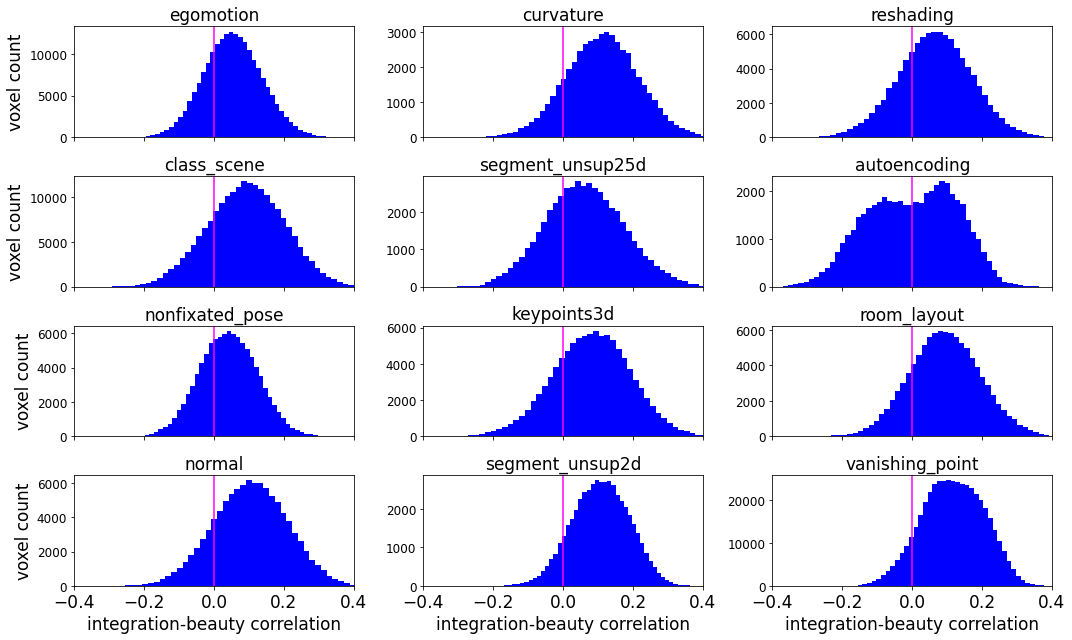

In [876]:
fig, axes = plt.subplots(4, 3, figsize=(15, 9), sharex=True, sharey=False)

for idx, mo, ax in zip(range(12), _models_ordered[::-1], axes.flat):
    if idx in (0, 3, 6, 9):
        ax.set_ylabel("voxel count")
    if idx in (9, 10, 11):
        ax.set_xlabel("integration-beauty correlation")

    subset_correlations.loc[mo].correlation.hist(bins=50, ax=ax, color="blue")
    ax.set_title(mo)
    ax.grid(visible=False)
    ax.axvline(color="magenta")
    ax.set_xlim(-0.4, 0.4)
fig.tight_layout()

## ammount of highly predictive subsets

In [349]:
subset_significance_ratio = (
    subset_significance.groupby("model").sum()
    / subset_significance.groupby("model").count()
)

Text(0.5, 0, 'ratio of significant voxels after MCC')

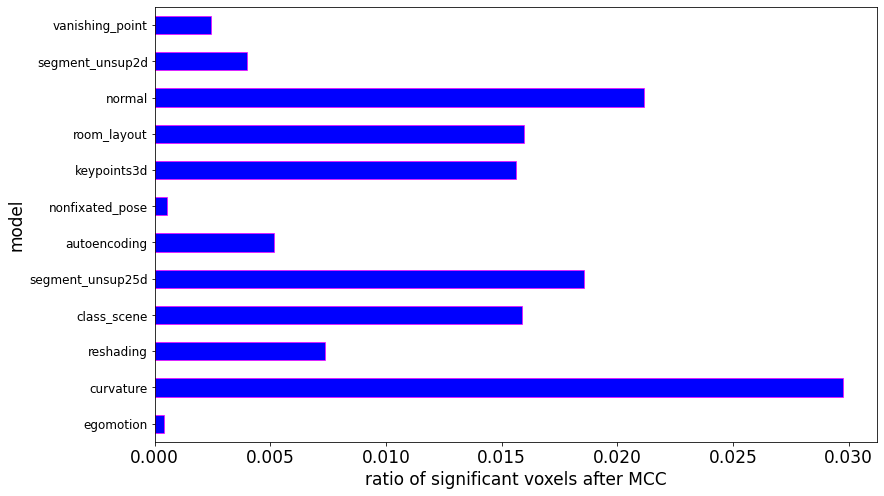

In [875]:
ax = subset_significance_ratio[_models_ordered[::-1]].plot.barh(
    color="blue", ec="magenta", linewidth=0.7, figsize=(8 * 1.618, 8)
)
ax.set_xlabel("ratio of significant voxels after MCC")

In [877]:
# compare localized integration and full integration

# map to 3D space

In [4]:
def run_mapsinglevoxelto3d(study, scale, model, layer, value):
    """Wrappern for map_singlevoxel_to_3d that handles saving and loading data
    Choose between mapping correlation or pvalue.

    """
    if value == "correlation":
        path = PATH_3DCORR

    if value == "pvalue":
        path = PATH_3DPVAL

    with open(
        os.path.join(path, scale, study + " " + model + " " + str(layer) + ".npy"),
        "wb",
    ) as file:
        np.save(
            file,
            map_singlevoxel_to_3d_(
                pd.read_hdf(
                    os.path.join(
                        PATH_SSIBC,
                        scale,
                        study + " " + model + " " + str(layer) + ".h5",
                    ),
                    key="subset_ibcorr",
                )[value],
                layer,
            ),
        )

## single voxel pvalues

all single models for cluster analysis <br> for p values, this is only feasible way since adding pvalues in cummolative way (as in mapping version below) makes no sense

### testing

In [5]:
scale = "scale2"
model = "reshading"
layer = 20
study = "study1"

In [15]:
df_subsetibc = pd.read_hdf(
    os.path.join(PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"),
    key="subset_ibcorr",
)
df_subsetibc

,correlation,pvalue
0,-0.089326,0.159101
1,-0.117885,0.062733
2,-0.154499,0.014473
3,-0.214258,0.000649
4,-0.219570,0.000470
...,...,...
24691,-0.107042,0.091246
24692,-0.127143,0.044601
24693,-0.143033,0.023706
24694,-0.120673,0.056727


In [17]:
df_subsetibc.shape[0]

24696

In [7]:
activation_extractor, layername = setup_singlelayer(model, layer)
dataset = ImageDataset(os.path.join(PATH_IMAGES, study2dataset(study), scale))
activation_shape = (
    list(activation_extractor(next(iter(dataset))[0]).values())[0].squeeze().shape
)
pat = PatternGeneratorSearchlight(
    activation_shape,
    layername,
)
ns = NetworkScorer({layername: activation_shape})

In [ ]:
singlescores3d = np.zeros(activation_shape)

for idx, score in enumerate(scores):
    singlescores3d[
        PatternGeneratorSearchlight._posnum_to_3Dindex(idx, activation_shape)
    ] = score

### scale2

In [43]:
scale = "scale2"
model = "reshading"
layer = 20

In [45]:
study = "study1"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

In [46]:
study = "study2"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

In [47]:
study = "study3"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

In [ ]:
study = "study4"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

### scale4

In [178]:
scale = "scale4"
model = "segment_unsup2d"
layer = 41

In [179]:
study = "study1"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

In [180]:
study = "study2"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

In [181]:
study = "study3"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

In [182]:
study = "study4"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

### scale 8

In [196]:
scale = "scale8"
model = "vanishing_point"
layer = 18

In [197]:
study = "study1"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

In [198]:
study = "study2"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

In [199]:
study = "study3"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

In [ ]:
study = "study4"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

### scale16

In [194]:
scale = "scale16"
model = "segment_unsup25d"
layer = 32

In [ ]:
study = "study1"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

In [ ]:
study = "study2"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

In [ ]:
study = "study3"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

In [ ]:
study = "study4"

with open(
    os.path.join(PATH_3DPVAL, scale, study + " " + model + " " + str(layer) + ".npy"),
    "wb",
) as file:
    np.save(
        file,
        map_singlevoxel_to_3d_(
            pd.read_hdf(
                os.path.join(
                    PATH_SSIBC, scale, study + " " + model + " " + str(layer) + ".h5"
                ),
                key="subset_ibcorr",
            ).pvalue,
            layer,
        ),
    )

## single voxel ibcorr

### scale2

In [ ]:
scale = "scale2"
model = "reshading"
layer = 20

In [136]:
run_mapsinglevoxelto3d("study1", scale, model, layer, "correlation")

In [137]:
run_mapsinglevoxelto3d("study2", scale, model, layer, "correlation")

In [184]:
run_mapsinglevoxelto3d("study3", scale, model, layer, "correlation")

In [ ]:
run_mapsinglevoxelto3d("study4", scale, model, layer, "correlation")

### scale4

In [10]:
scale = "scale4"
model = "segment_unsup2d"
layer = 41

In [11]:
run_mapsinglevoxelto3d("study1", scale, model, layer, "correlation")

In [12]:
run_mapsinglevoxelto3d("study2", scale, model, layer, "correlation")

In [13]:
run_mapsinglevoxelto3d("study3", scale, model, layer, "correlation")

In [14]:
run_mapsinglevoxelto3d("study4", scale, model, layer, "correlation")

### scale8

In [17]:
scale = "scale8"
model = "vanishing_point"
layer = 18

In [18]:
run_mapsinglevoxelto3d("study1", scale, model, layer, "correlation")

In [19]:
run_mapsinglevoxelto3d("study2", scale, model, layer, "correlation")

In [20]:
run_mapsinglevoxelto3d("study3", scale, model, layer, "correlation")

In [ ]:
run_mapsinglevoxelto3d("study4", scale, model, layer, "correlation")

# (old) overlap of top 10% of (unclustered) predictive voxels
quick test if top10% cluster at all

In [ ]:
scale = "scale2"
model = "reshading"
layer = 20

In [ ]:
study = "study1"

with open(
    os.path.join(PATH_3DCORR, scale, study + " " + model + " " + str(layer) + ".npy"),
    "rb",
) as file:
    # flipping of sign is currently missing in calculation of integration
    corr3d_st1 = -np.load(file)

In [ ]:
study = "study2"

with open(
    os.path.join(PATH_3DCORR, scale, study + " " + model + " " + str(layer) + ".npy"),
    "rb",
) as file:
    # flipping of sign is currently missing in calculation of integration
    corr3d_st2 = -np.load(file)

In [ ]:
study = "study3"

with open(
    os.path.join(PATH_3DCORR, scale, study + " " + model + " " + str(layer) + ".npy"),
    "rb",
) as file:
    # flipping of sign is currently missing in calculation of integration
    corr3d_st3 = -np.load(file)

In [ ]:
q90_st1 = np.quantile(corr3d_st1.flatten(), 0.9)
q90_st1

0.2331098471729129

In [ ]:
q90_st2 = np.quantile(corr3d_st2.flatten(), 0.9)
q90_st2

0.21450488659343914

In [ ]:
q90_st3 = np.quantile(corr3d_st3.flatten(), 0.9)
q90_st3

0.23174331077878463

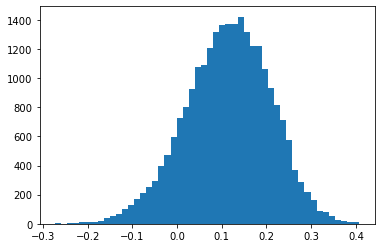

In [ ]:
plt.hist(corr3d_st1.flatten(), bins=50)

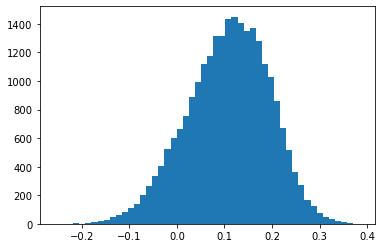

In [ ]:
plt.hist(corr3d_st2.flatten(), bins=50)

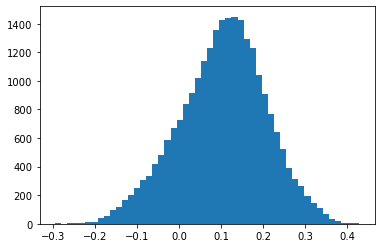

In [ ]:
plt.hist(corr3d_st3.flatten(), bins=50)

In [ ]:
m1 = corr3d_st1 > q90_st1

In [ ]:
m2 = corr3d_st2 > q90_st2

In [ ]:
m3 = corr3d_st3 > q90_st3

In [ ]:
m1.shape, 126 * 14 * 14

((126, 14, 14), 24696)

In [ ]:
# this may be rougly the shape of a large cluster of highly predictive voxels
100 * 5 * 5

2500

In [ ]:
m1.sum()

2470

In [ ]:
m2.sum()

2470

In [ ]:
m3.sum()

2470

In [ ]:
(m1 & m2).sum()

1608

In [ ]:
(m1 & m3).sum()

910

In [ ]:
(m2 & m3).sum()

764

In [ ]:
# significant overlap: permutation testing
# permutation: how much do cluters from randomized scores overlap ?

In [ ]:
m1.shape

(126, 14, 14)

# filter clusters
of top10% correlation <br>

input: 3D data <br>

calculate significant clusters in data by cluster based permutation testing <br>

### testing

In [29]:
scale = "scale2"
model = "reshading"
layer = 20
study = "study1"

In [43]:
with open(
    os.path.join(PATH_3DCORR, scale, study + " " + model + " " + str(layer) + ".npy"),
    "rb",
) as file:
    subset_ibcorr_3d = -np.load(file)

subset_ibcorr_3d.shape

(126, 14, 14)

In [118]:
with open(
    os.path.join(
        PATH_PERMDISTR_TOPVOXELS_CLUSTERSIZE,
        scale,
        "permdistr " + study + " " + model + " " + str(layer) + ".npy",
    ),
    "rb",
) as file:
    permdistr = np.load(file)

In [119]:
permdistr

array([185, 241])

In [125]:
threshold = np.quantile(permdistr, .95)

In [44]:
threshold = 100

In [45]:
subset_ibcorr_3d = subset_ibcorr_3d > np.quantile(subset_ibcorr_3d.flat, 0.9)

In [46]:
cluster_list = find_clusters(subset_ibcorr_3d)

In [47]:
cluster_sizes = np.array([np.sum(cluster) for cluster in cluster_list])

In [48]:
significant_clusters = [cluster_list[idx] for idx in np.where(cluster_sizes > threshold)[0]]

In [49]:
all_clustered_topvoxels = np.logical_or.reduce(significant_clusters)

In [ ]:
with open(
    os.path.join(
        PATH_SIGNICLUST,
        scale,
        "signiclusteredcorr " + study + " " + model + " " + str(layer) + ".npy",
    ),
    "wb",
) as file:
    np.save(file, )

## permutation tests

### functions

#### cluster-size permutation-distribution

In [ ]:
def permutation_distribtion_top10(
    df_subset_integration,
    beauty_ratings,
    layer_idx,
    n_permutations=1000,
    quant=0.9,
):
    """
    Generate permutation distribution for cluster size.
    Either for clusters of any significant voxels

    Parameters
    ----------

    df_subset_integration: pd.DataFrame
        subsets in rows, images in columns

    beauty_ratings: pd.DataFrame
        image beauty ratings

    layer_idx: int

    n_permutations: int
        Higher values for a more exact permutation distribution, typically 1000 or 10 000.

    alpha: float
        Significance level (no MCC of individual voxels in permutation testing)

    Returns
    -------

    maxclustersized: np.array
        Permutation distribution: n_permutations-sized array of the maximum cluster size of each permutation
    """
    maxclustersizes = []

    for i in tqdm(range(n_permutations)):
        # randomized ibcorr
        df_subset_ibcorr = df_subset_integration.apply(
            lambda r: pd.Series(spearmanr(r, beauty_ratings.sample(frac=1))),
            axis=1,
        ).rename({0: "correlation", 1: "pvalue"}, axis=1)

        # mask voxels above 90th correlation quantile
        subset_ibcorr_3d = map_singlevoxel_to_3d_(
            df_subset_ibcorr.correlation, layer_idx
        )
        subset_ibcorr_3d = subset_ibcorr_3d > np.quantile(
            df_subset_ibcorr.correlation, quant
        )

        # clusters
        cluster_list = find_clusters(subset_ibcorr_3d)

        # largest cluster
        cluster_sizes = [np.sum(cluster) for cluster in cluster_list]

        # save
        if len(cluster_sizes) > 0:
            maxclustersizes.append(max(cluster_sizes))
        else:
            maxclustersizes.append(0)  # no cluster

    return np.array(maxclustersizes)

#### run cluster-size permutation-distribution top10

In [ ]:
# permutation test size for all tets
n_permutations = 1000


def run_permutationdistributiontop10(scale, model, layer, study, n_permutations):
    """
    Wrapper around permutation_distribution() that handles
    loading input and saving output for the given data.

    Calculates permutation distribution of cluster sizes by shuffling image ratings.

    """
    with open(
        os.path.join(
            PATH_PERMDISTR_TOPVOXELS_CLUSTERSIZE,
            scale,
            "permdistr " + study + " " + model + " " + str(layer) + ".npy",
        ),
        "wb",
    ) as file:
        np.save(
            file,
            permutation_distribtion_top10(
                pd.read_hdf(
                    os.path.join(
                        PATH_SSINT,
                        scale,
                        study2dataset(study) + " " + model + " " + str(layer) + ".h5",
                    ),
                    key="subset integration",
                ),
                studyratings(study),
                layer,
                n_permutations,
            ),
        )

### scale2

In [116]:
scale = "scale2"
model = "reshading"
layer = 20

In [117]:
study = "study1"
run_permutationdistributiontop10(scale, model, layer, study, n_permutations)

In [ ]:
study = "study2"
run_permutationdistributiontop10(scale, model, layer, study, n_permutations)

In [ ]:
study = "study3"
run_permutationdistributiontop10(scale, model, layer, study, n_permutations)

### scale4

In [70]:
scale = "scale4"
model = "segment_unsup2d"
layer = 41

In [ ]:
study = "study1"
# ran 777min
run_permutationdistributiontop10(scale, model, layer, study, 1000)

In [ ]:
scale = "scale8"
model = "vanishing_point"
layer = 18

In [ ]:
study = "study1"
run_permutationdistributiontop10(scale, model, layer, study, 1000)

## filter clustered values
calculate threshold from permutation distributions

### functions

#### filter clustered values

In [ ]:
def filter_clusters(data3d, min_cs: int):
    """
    Filter input 3d-data to retain only data that is in clusters of at least size min_cs.

    
    Parameters
    ----------
    data_3d: np.ndarray
        boolean array

    min_cs: int
        cluster size to threshold. Most likely 95th quantile of cluster size permutation distribution.
    
    Returns
    -------
    3d-array: np.ndarray
        Same data as input, but with unclustered and clusters below threshold data removed. (removed: bool set to false)


    """
    cl = find_clusters(data3d)
    cl_sizes = np.array([np.sum(c) for c in cl])
    cl_signi = [cl[idx] for idx in np.where(cl_sizes > min_cs)[0]]
    return np.logical_or.reduce(cl_signi)

#### run filter clustered values

In [ ]:
def run_filterclusters(
    scale, study, model, layer, cluster_size_threshold, topquantile=0.9
):
    with open(
        os.path.join(
            PATH_3DCORR, scale, study + " " + model + " " + str(layer) + ".npy"
        ),
        "rb",
    ) as file:
        subset_ibcorr_3d = -np.load(file)

    subset_ibcorr_3d = subset_ibcorr_3d > np.quantile(subset_ibcorr_3d.flat, 0.9)

    with open(
        os.path.join(
            PATH_SIGNICLUST,
            scale,
            "signiclusteredcorr " + study + " " + model + " " + str(layer) + ".npy",
        ),
        "wb",
    ) as file:
        np.save(file, filter_clusters(subset_ibcorr_3d, cluster_size_threshold))

In [24]:
threshold=100

### scale2

In [ ]:
# need to run these again with threshold from permutation distribution

In [51]:
scale = "scale2"
model = "reshading"
layer = 20

In [52]:
study = "study1"
run_filterclusters(scale, study, model, layer, threshold)

In [53]:
study = "study2"
run_filterclusters(scale, study, model, layer, threshold)

In [54]:
study = "study3"
run_filterclusters(scale, study, model, layer, threshold)

### scale4

In [55]:
scale = "scale4"
model = "segment_unsup2d"
layer = 41

In [56]:
study = "study1"
run_filterclusters(scale, study, model, layer, threshold)

In [57]:
study = "study2"
run_filterclusters(scale, study, model, layer, threshold)

In [58]:
study = "study3"
run_filterclusters(scale, study, model, layer, threshold)

### scale8

In [59]:
scale = "scale8"
model = "vanishing_point"
layer = 18

In [60]:
study = "study1"
run_filterclusters(scale, study, model, layer, threshold)

In [61]:
study = "study2"
run_filterclusters(scale, study, model, layer, threshold)

In [62]:
study = "study3"
run_filterclusters(scale, study, model, layer, threshold)

### scale16

In [ ]:
scale = "scale16"
model = "segment_unsup25d"
layer = 32

# 3D-plot clusters
"highly predictive voxels are clustered"

of single net <br>


## functions

In [63]:
def plot_3dvoxels_singlearray(arr, study1, scale, model, layer, alpha=1.0):
    with PdfPages(
        os.path.join(
            PATH_RESULTS,
            "spatial integration",
            "3D plots",
            scale,
            model + " " + study1 + " " + str(layer) + ".pdf",
        )
    ) as pdf:
        fontsize_axislabel = 20

        for fn in range(0, arr.shape[0], 25):
            ax = plt.figure(figsize=(16, 10)).add_subplot(projection="3d")
            ax.voxels(
                all_clustered_topvoxels[fn : fn + 25 + 1].astype(bool),
                facecolors="magenta",
            )
            ax.set_xlabel("convolutional filter", fontsize=fontsize_axislabel)
            ax.set_ylabel("conv-layer x-axis", fontsize=fontsize_axislabel)
            ax.set_zlabel("conv-layer y-axis", fontsize=fontsize_axislabel)
            ax.set_title(
                "inside best predicting convolutional layer (scale2, study1)",
                fontsize=fontsize_axislabel,
            )
            # ax.set_xticks()
            ax.set_xlim(0, 25)
            ax.set_xticklabels(range(fn, fn + 25 + 1, 5))

            pdf.savefig()
            plt.close()

## testing

[Text(0, 0, '50'),
 Text(0, 0, '55'),
 Text(0, 0, '60'),
 Text(0, 0, '65'),
 Text(0, 0, '70'),
 Text(0, 0, '75')]

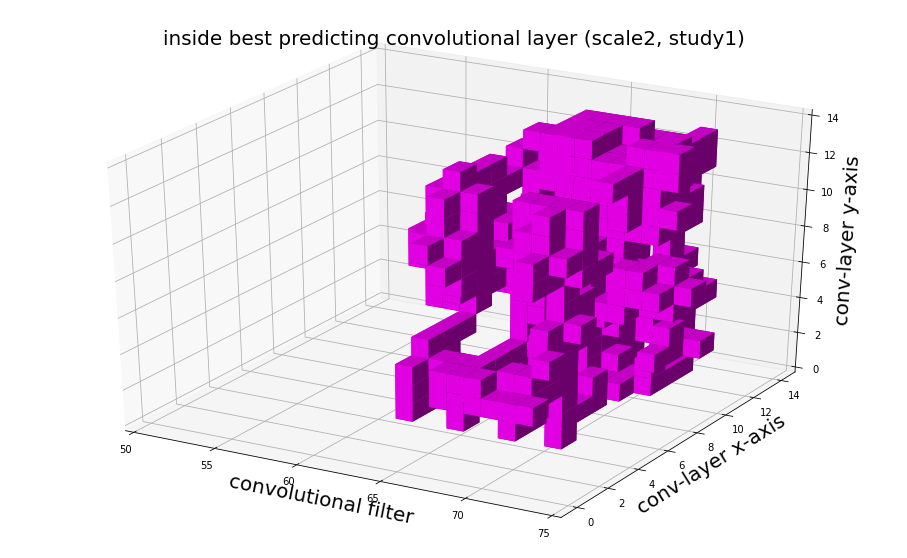

In [172]:
fontsize_axislabel = 20
start_filternum = 50
fn = start_filternum
ax = plt.figure(figsize=(16, 10)).add_subplot(projection="3d")
ax.voxels(all_clustered_topvoxels[fn : fn + 25 + 1].astype(bool), facecolors="magenta")
ax.set_xlabel("convolutional filter", fontsize=fontsize_axislabel)
ax.set_ylabel("conv-layer x-axis", fontsize=fontsize_axislabel)
ax.set_zlabel("conv-layer y-axis", fontsize=fontsize_axislabel)
ax.set_title(
    "inside best predicting convolutional layer (scale2, study1)",
    fontsize=fontsize_axislabel,
)
# ax.set_xticks()
ax.set_xlim(0, 25)
ax.set_xticklabels(range(fn, fn + 25 + 1, 5))

## plot

In [175]:
plot_3dvoxels_singlearray(all_clustered_topvoxels, study, scale, model, layer)

In [ ]:
# spatial correlation per image per net, correlate these netXnet
# test if integration scores are still correlating to beauty

# cluster overlap
"clusters of highly predictive voxels are partially robust for a network"

calculate cluster overlap <br>


### functions

In [7]:
def plot_3dvoxels_twoarrays(arr1, arr2, study1, study2, scale, model, layer, alpha=1.0):
    with PdfPages(
        os.path.join(
            PATH_RESULTS,
            "spatial integration",
            "3D plots",
            scale,
            model + " " + study1 + " vs " + study2 + " | layer " + str(layer) + ".pdf",
        )
    ) as pdf:

        for fn in range(0, arr1.shape[0], 25):
            ax = plt.figure(figsize=(16, 10)).add_subplot(projection="3d")
            ax.voxels(arr1[fn : fn + 25].astype(bool), facecolors="magenta", alpha=alpha, label=study1)
            ax.voxels(arr2[fn : fn + 25].astype(bool), facecolors="blue", alpha=alpha, label=study2)
            ax.set_xlabel("convolutional filter", fontsize=fontsize_axislabel)
            ax.set_ylabel("conv-layer x-axis", fontsize=fontsize_axislabel)
            ax.set_zlabel("conv-layer y-axis", fontsize=fontsize_axislabel)
            ax.set_title(
                "inside best predicting convolutional layer (scale2, pink: study1 (places1), blue: study3 (places2))",
                fontsize=fontsize_axislabel,
            )
            #plt.legend()
            # ax.set_xticks()
            ax.set_xlim(0, 25)
            ax.set_xticklabels(range(fn, fn + 25 + 1, 5))

            pdf.savefig()
            plt.close()

## between studies

### overlapping degree (coeffiecient)
ratio of overlapping clustered voxels

### plot clusters from combinations of two studies

In [ ]:
scale = "scale2"
model = "reshading"
layer = 20

In [178]:
m1 = all_clustered_topvoxels

In [191]:
m2 = all_clustered_topvoxels

In [200]:
plot_3dvoxels_twoarrays(m1, m2, "study1", "study3", scale, model, layer, alpha=0.385)

## between scales

### scale2 vs scale8 (study1)

In [4]:
scale = "scale2"
model = "reshading"
layer = 20

In [5]:
study = "study1"

In [8]:
with open(
    os.path.join(
        PATH_SIGNICLUST,
        scale,
        "signiclusteredcorr " + study + " " + model + " " + str(layer) + ".npy",
    ),
    "rb",
) as file:
    data1 = np.load(file)

In [ ]:
scale = "scale8"
model = "vanishing_point"
layer = 18

In [9]:
with open(
    os.path.join(
        PATH_SIGNICLUST,
        scale,
        "signiclusteredcorr " + study + " " + model + " " + str(layer) + ".npy",
    ),
    "rb",
) as file:
    data2 = np.load(file)

In [ ]:
plot_3dvoxels_twoarrays(data1, data2, "study1", "study3", scale, model, layer, alpha=0.385)